<a href="https://colab.research.google.com/github/maharjanprajjwal/Weather-Prediction-Model-Training/blob/main/coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing libraries necessary
import pandas as pd
import numpy as np
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#Loading weather dataset
df = pd.read_csv("/data2.csv")

In [ ]:
df.head()

,time,temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),wind_speed_10m (km/h),wind_speed_100m (km/h),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³)
0,2022-08-05T00:00,20.3,98.0,23.7,3.1,4.4,0.426,0.429
1,2022-08-05T01:00,21.0,96.0,24.8,1.8,3.0,0.425,0.428
2,2022-08-05T02:00,21.7,93.0,25.4,3.1,4.4,0.424,0.427
3,2022-08-05T03:00,23.2,86.0,27.0,3.1,4.0,0.423,0.426
4,2022-08-05T04:00,25.1,76.0,28.9,2.1,2.6,0.421,0.425


In [ ]:
df.describe()

,temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),wind_speed_10m (km/h),wind_speed_100m (km/h),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³)
count,22489.000000,22489.000000,22489.000000,22489.000000,22489.000000,22489.000000,22489.000000
mean,17.919721,74.457112,18.673707,4.023171,5.013309,0.293815,0.305105
std,5.858300,20.121455,7.672883,2.262108,3.279604,0.105452,0.090636
min,1.300000,7.000000,-1.600000,0.000000,0.000000,0.102000,0.152000
25%,13.300000,61.000000,12.500000,2.400000,2.600000,0.207000,0.224000
50%,19.000000,79.000000,19.200000,3.600000,4.300000,0.302000,0.305000
75%,22.100000,92.000000,25.100000,5.200000,6.600000,0.401000,0.401000
max,32.600000,100.000000,35.800000,18.800000,26.800000,0.432000,0.433000


In [ ]:
#computers dont understand dates in yyyy-mm-dd format so we break them into separate numbers for housr, day and month
df['time'] = pd.to_datetime(df['time']) # Convert the time column into datetime format
df['hour'] = df['time'].dt.hour # Take only the hour from the time
df['day'] = df['time'].dt.day # Take only the day from the date
df['month'] = df['time'].dt.month  # Take only the month from the date

df.drop(columns=['time'], inplace=True) # Remove the original time column since it is no longer needed

In [ ]:
#interpolate fills missing value, it fills gap looking at the number before and after
df = df.interpolate(method='linear')

In [ ]:
# removing apparent_temperature bechaus its basically the answer, we want model to predict from scratch
df_clean = df.drop(columns=['apparent_temperature (°C)', 'wind_speed_100m (km/h)'])


In [ ]:
# this function finds outliers (values that are too high or too low) and removes them so model dosent get confused
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1 #calculate interquartile range
    lower_bound = Q1 - 1.5 * IQR #set the lower limit for normal values
    upper_bound = Q3 + 1.5 * IQR #set the upper limit for normal values
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]  # Keep only values inside the range

In [ ]:
# Loop through each important column and remove extreme values from it
for col in ['temperature_2m (°C)', 'relative_humidity_2m (%)', 'wind_speed_10m (km/h)']:
    df_clean = remove_outliers(df_clean, col)

In [ ]:
df.tail()


,temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),wind_speed_10m (km/h),wind_speed_100m (km/h),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),hour,day,month
22531,8.3,93.0,7.1,3.5,2.8,0.262,0.28,19,28,2
22532,8.3,93.0,7.1,3.5,2.8,0.262,0.28,20,28,2
22533,8.3,93.0,7.1,3.5,2.8,0.262,0.28,21,28,2
22534,8.3,93.0,7.1,3.5,2.8,0.262,0.28,22,28,2
22535,8.3,93.0,7.1,3.5,2.8,0.262,0.28,23,28,2


In [ ]:
#definign X and y, separating target(y: what we want to predict) from the features(X: the clues)
X = df_clean.drop("temperature_2m (°C)", axis=1) #Features (all colums except temp)
y = df_clean["temperature_2m (°C)"] #Target (only temp column)

In [ ]:
# Split the data: 80% for training the model and 20% for testing how well it learned
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42  # random_state keeps the split the same every time
)

In [ ]:
#Linear Regression
lr = LinearRegression()
# train model
lr.fit(X_train, y_train)
# make prediction
y_pred_lr = lr.predict(X_test)

print("Linear Regression Performance")
print("MAE:", mean_absolute_error(y_test, y_pred_lr)) # Mean Absolute Error: average absolute difference between actual and predicted values
print("MSE:", mean_squared_error(y_test, y_pred_lr)) # Mean Squared Error: average of squared differences (penalizes large errors more)
print("R2 Score:", r2_score(y_test, y_pred_lr)) #R2 Score is like the percentage of accuracy (1.0 is perfect)

Linear Regression Performance
MAE: 3.0156065240820173
MSE: 16.064296414527366
R2 Score: 0.5187042276053987


In [ ]:
#Random Forest Regression
#Creates a random forest regressor model with 100 decision trees
rf = RandomForestRegressor(
    n_estimators=100, #number of trees
    random_state=42 # Ensures reproducible results
)
# train model
rf.fit(X_train, y_train)

# make prediction
y_pred_rf = rf.predict(X_test)

print("Random Forest Regression Performance")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("R2 Score:", r2_score(y_test, y_pred_rf))

Random Forest Regression Performance
MAE: 0.5392498860009122
MSE: 0.5328786570907432
R2 Score: 0.9840346419015804


In [ ]:
#XGBoost Regressor
# creating xgboost regressor with 100 trees, learning rate 0.1 and max depth 5
xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
# train model
xgb.fit(X_train, y_train)
# make prediction
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Regression Performance")
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("MSE:", mean_squared_error(y_test, y_pred_xgb))
print("R2 Score:", r2_score(y_test, y_pred_xgb))

XGBoost Regression Performance
MAE: 0.7343808151519956
MSE: 0.9023665257589982
R2 Score: 0.9729645679592007


In [ ]:
# Creating a summary table to compare the performance of different models
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "XGBoost"],
    "MAE": [
        mean_absolute_error(y_test, y_pred_lr),
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, y_pred_xgb)
    ],
    "MSE": [
        mean_squared_error(y_test, y_pred_lr),
        mean_squared_error(y_test, y_pred_rf),
        mean_squared_error(y_test, y_pred_xgb)
    ],
    "R2 Score": [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_xgb)
    ]
})

results

,Model,MAE,MSE,R2 Score
0,Linear Regression,3.015607,16.064296,0.518704
1,Random Forest,0.539250,0.532879,0.984035
2,XGBoost,0.734381,0.902367,0.972965


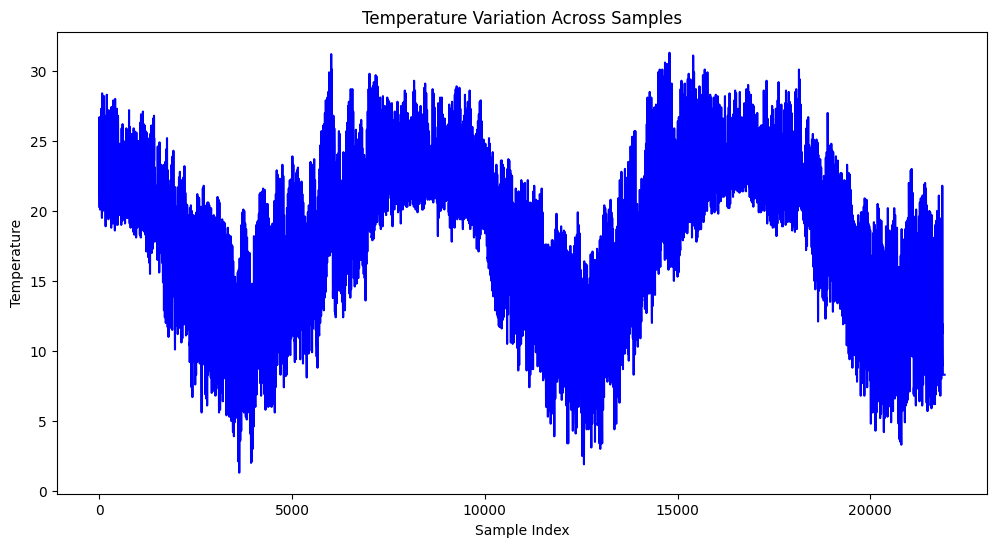

In [ ]:
# Data Visualization (Temperature values of dataset)
plt.figure(figsize=(12, 6))
plt.plot(y.values, color='blue', label='Temperature')  # Temperature values

plt.xlabel("Sample Index")
plt.ylabel("Temperature")
plt.title("Temperature Variation Across Samples")
plt.show()

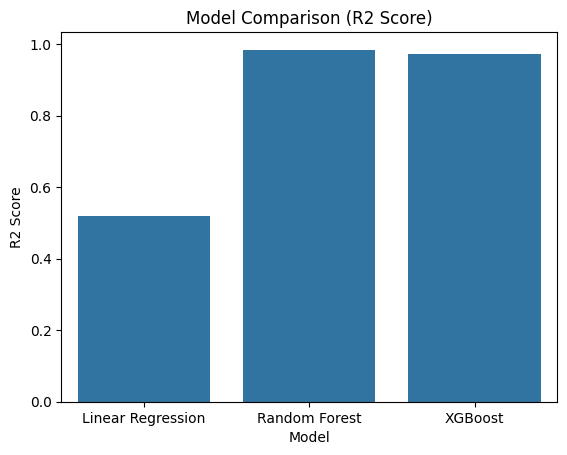

In [ ]:
# barchart to compare the R2 score of each model
sns.barplot(x="Model", y="R2 Score", data=results)
plt.title("Model Comparison (R2 Score)")
plt.show()

In [ ]:
#convert the results Dataframe from wide to long format for easier plotting
results_long = results.melt(
    id_vars="Model",
    value_vars=["MAE", "MSE"],
    var_name="Metric",
    value_name="Value"
)

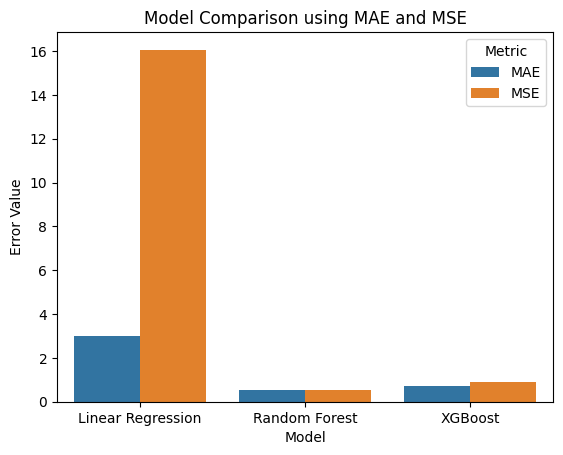

In [ ]:
# plotting a grouped barchart to compare MAE and MSE across models
sns.barplot(x="Model", y="Value", hue="Metric", data=results_long)
plt.title("Model Comparison using MAE and MSE")
plt.ylabel("Error Value")
plt.show()

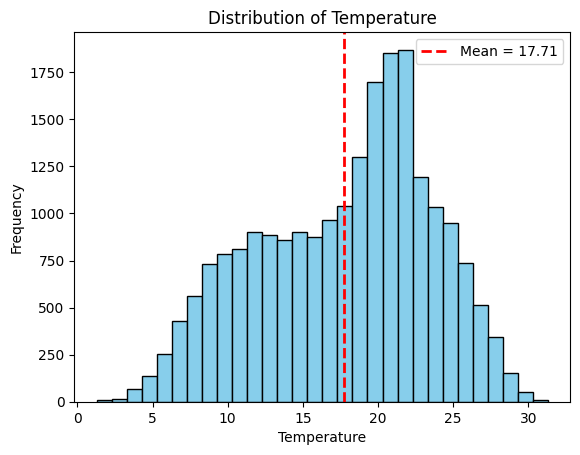

In [ ]:
# Calculate the mean of the temperature
mean_temp = np.mean(y)

# Creating a histogram to visualize temperature distribution
plt.figure()
plt.hist(y, bins=30, color='skyblue', edgecolor='black')  # Histogram of temperatures
plt.axvline(mean_temp, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_temp:.2f}')  # Add mean line
plt.title("Distribution of Temperature")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()  # Show the legend for the mean line
plt.show()

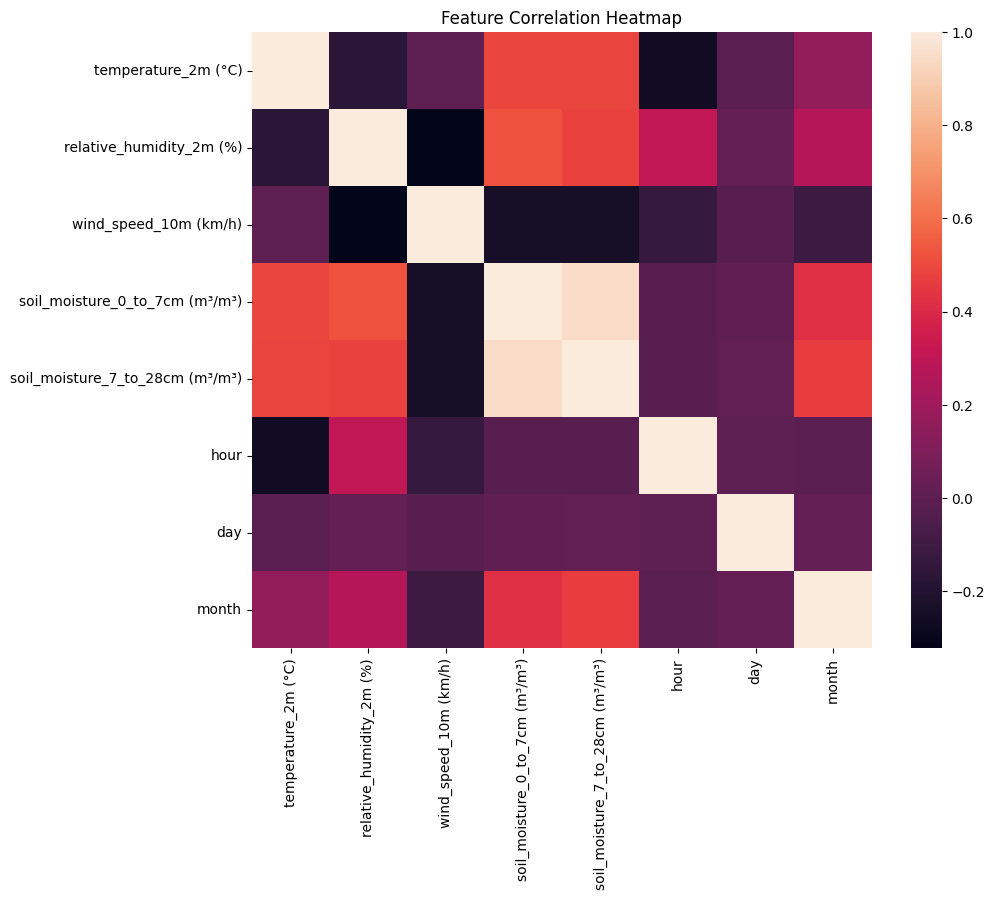

In [ ]:
# heat map to show coreraltion between features
plt.figure(figsize=(10, 8))
df_numeric = df_clean.select_dtypes(include=np.number)
corr = df_numeric.corr()

sns.heatmap(corr, annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

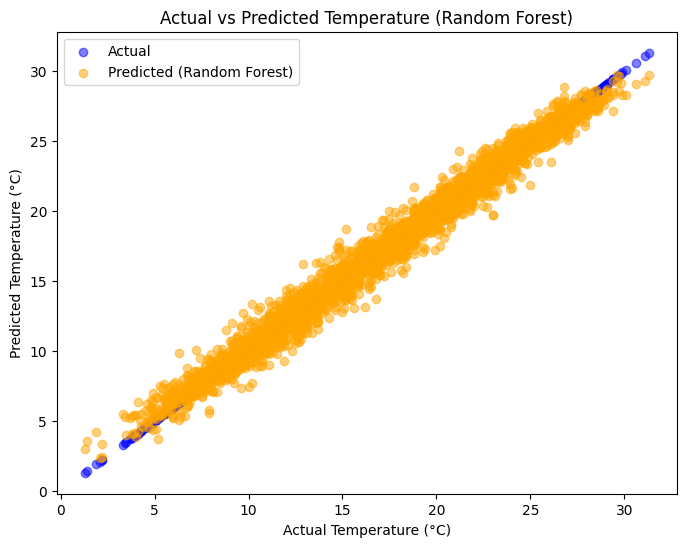

In [ ]:
plt.figure(figsize=(8, 6))

# Plotting the 'Actual' points (Blue)
plt.scatter(y_test, y_test, color='blue', label='Actual', alpha=0.5)

# Plotting the 'Predicted' points for Random Forest (orange)
plt.scatter(y_test, y_pred_rf, color='orange', label='Predicted (Random Forest)', alpha=0.5)

plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.title("Actual vs Predicted Temperature (Random Forest)")
plt.legend()
plt.show()

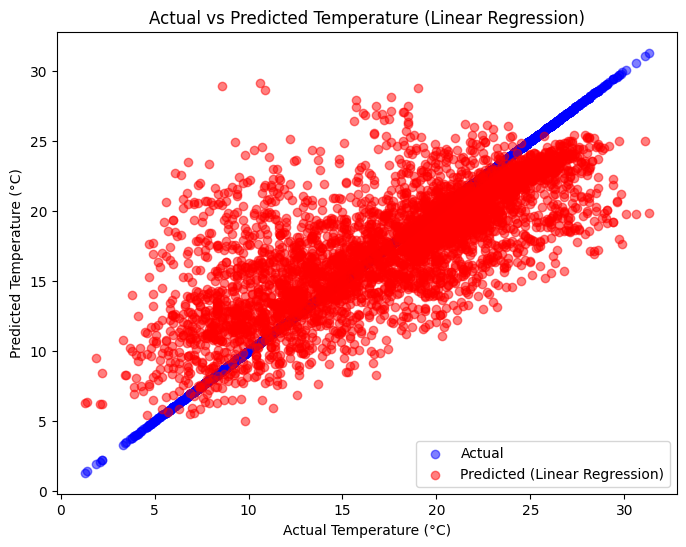

In [ ]:
# Scatter plot for Linear Regression
plt.figure(figsize=(8, 6))

# Plot actual vs actual (the reference line)
plt.scatter(y_test, y_test, color='blue', label='Actual', alpha=0.5)
# Plot actual vs predicted
plt.scatter(y_test, y_pred_lr, color='red', label='Predicted (Linear Regression)', alpha=0.5)

plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.title("Actual vs Predicted Temperature (Linear Regression)")
plt.legend()
plt.show()

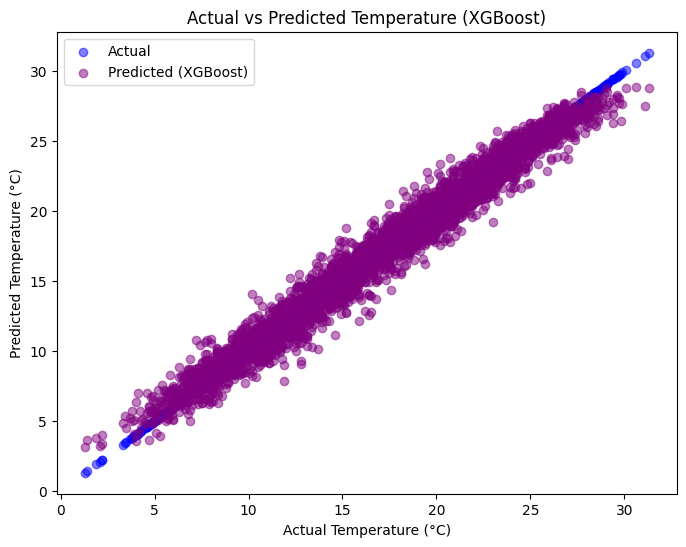

In [ ]:
# Scatter plot for XGBoost
plt.figure(figsize=(8, 6))

# Plot actual vs actual
plt.scatter(y_test, y_test, color='blue', label='Actual', alpha=0.5)
# Plot actual vs predicted
plt.scatter(y_test, y_pred_xgb, color='purple', label='Predicted (XGBoost)', alpha=0.5)

plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.title("Actual vs Predicted Temperature (XGBoost)")
plt.legend()
plt.show()

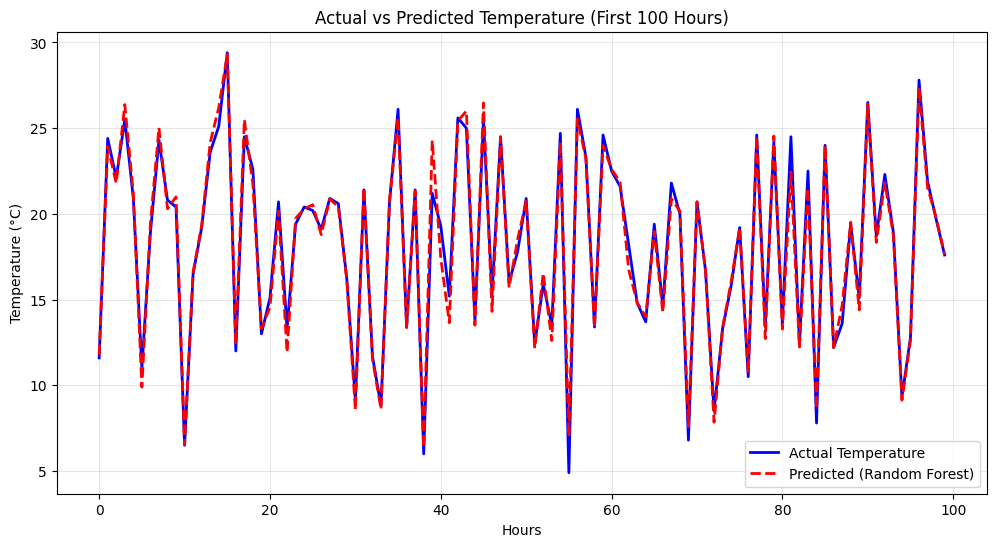

In [ ]:
#Selecting the first 100 points for clarity
subset_n = 100
y_test_subset = y_test[:subset_n].values
y_pred_subset = y_pred_rf[:subset_n]  # Using Random Forest predictions

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test_subset, label='Actual Temperature', color='blue', linewidth=2)          # Actual temperatures
plt.plot(y_pred_subset, label='Predicted (Random Forest)', color='red', linestyle='--', linewidth=2)  # RF predictions

plt.title(f"Actual vs Predicted Temperature (First {subset_n} Hours)")
plt.xlabel("Hours")               # X-axis: sample index (interpreted as hours)
plt.ylabel("Temperature (°C)")   # Y-axis: temperature values
plt.legend()                      # Show labels for actual and predicted
plt.grid(True, alpha=0.3)         # Add light grid for easier reading
plt.show()


In [ ]:
# Select last 24 records from the dataset
last_24 = df_clean.tail(24)

# Separate features and actual temperature
X_last_24 = last_24.drop(columns=['temperature_2m (°C)'])
y_actual_last_24 = last_24['temperature_2m (°C)']

# Predict using trained Random Forest
y_pred_last_24 = rf.predict(X_last_24)

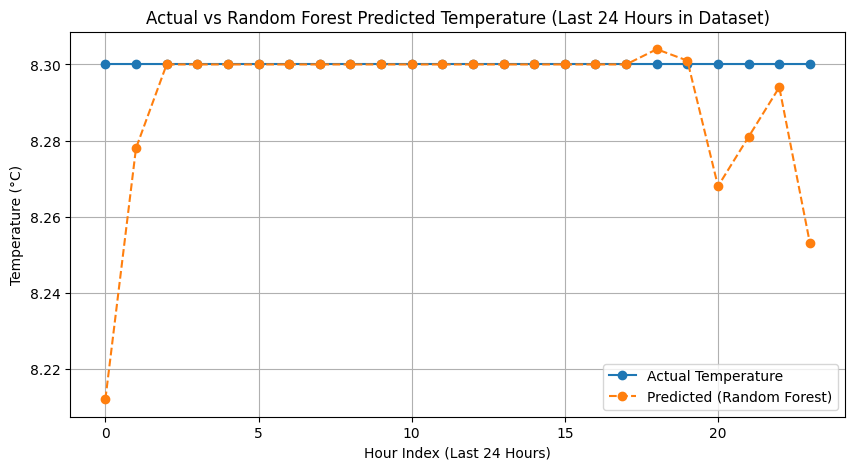

In [ ]:
# Plot comparison
plt.figure(figsize=(10,5))
plt.plot(range(24), y_actual_last_24.values, marker='o', label='Actual Temperature')
plt.plot(range(24), y_pred_last_24, marker='o', linestyle='--', label='Predicted (Random Forest)')
plt.xlabel("Hour Index (Last 24 Hours)")
plt.ylabel("Temperature (°C)")
plt.title("Actual vs Random Forest Predicted Temperature (Last 24 Hours in Dataset)")
plt.legend()
plt.grid(True)
plt.show()